In [ ]:
!pip install openmeteo-requests requests-cache retry-requests

In [ ]:
import pandas as pd
import openmeteo_requests
import requests_cache
from retry_requests import retry
import time
import os

# --- STEP 1: LOAD & PREPARE DATA ---
file_path = '/content/drive/MyDrive/crop data/Tamilnadu agriculture yield data.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)

    # Basic Cleaning to ensure we have the columns we need
    # Convert District_Name to string and Crop_Year to int just in case
    df['District_Name'] = df['District_Name'].astype(str).str.strip()
    df['Crop_Year'] = pd.to_numeric(df['Crop_Year'], errors='coerce')
    df = df.dropna(subset=['District_Name', 'Crop_Year'])
    df['Crop_Year'] = df['Crop_Year'].astype(int)

    print(f"Data Loaded! Found {len(df)} rows.")
    print(f"Columns: {list(df.columns)}")
else:
    raise FileNotFoundError(f"Could not find {file_path}. Please check the 'data' folder.")

# --- STEP 2: SETUP WEATHER API ---
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Map TN Districts to Lat/Long (Updated to match common spellings in your CSV)
district_coords = {
    'ARIYALUR': {'lat': 11.1401, 'lon': 79.0786},
    'COIMBATORE': {'lat': 11.0168, 'lon': 76.9558},
    'CUDDALORE': {'lat': 11.7480, 'lon': 79.7714},
    'DHARMAPURI': {'lat': 12.1211, 'lon': 78.1582},
    'DINDIGUL': {'lat': 10.3673, 'lon': 77.9803},
    'ERODE': {'lat': 11.3410, 'lon': 77.7172},
    'KANCHEEPURAM': {'lat': 12.8185, 'lon': 79.6947},
    'KANYAKUMARI': {'lat': 8.0883, 'lon': 77.5385},
    'KARUR': {'lat': 10.9601, 'lon': 78.0766},
    'KRISHNAGIRI': {'lat': 12.5186, 'lon': 78.2137},
    'MADURAI': {'lat': 9.9252, 'lon': 78.1198},
    'NAGAPATTINAM': {'lat': 10.7672, 'lon': 79.8449},
    'NAMAKKAL': {'lat': 11.2148, 'lon': 78.1702},
    'PERAMBALUR': {'lat': 11.2358, 'lon': 78.8810},
    'PUDUKKOTTAI': {'lat': 10.3797, 'lon': 78.8208},
    'RAMANATHAPURAM': {'lat': 9.3639, 'lon': 78.8395},
    'SALEM': {'lat': 11.6643, 'lon': 78.1460},
    'SIVAGANGA': {'lat': 9.8433, 'lon': 78.4809},
    'THANJAVUR': {'lat': 10.7870, 'lon': 79.1378},
    'THE NILGIRIS': {'lat': 11.4102, 'lon': 76.6950},
    'THENI': {'lat': 10.0104, 'lon': 77.4768},
    'THIRUVALLUR': {'lat': 13.1430, 'lon': 79.8954},
    'THIRUVARUR': {'lat': 10.7766, 'lon': 79.6344},
    'THOOTHUKKUDI': {'lat': 8.7642, 'lon': 78.1348},
    'TIRUCHIRAPPALLI': {'lat': 10.7905, 'lon': 78.7047},
    'TIRUNELVELI': {'lat': 8.7139, 'lon': 77.7567},
    'TIRUPPUR': {'lat': 11.1085, 'lon': 77.3411},
    'TIRUVANNAMALAI': {'lat': 12.2253, 'lon': 79.0747},
    'VELLORE': {'lat': 12.9165, 'lon': 79.1325},
    'VILLUPURAM': {'lat': 11.9401, 'lon': 79.4861},
    'VIRUDHUNAGAR': {'lat': 9.5680, 'lon': 77.9624},
}

def get_annual_weather(district, year):
    # Normalize name: Uppercase and strip spaces
    district_clean = district.upper().strip()

    if district_clean not in district_coords:
        # Debug print once per missing district to avoid spam
        # print(f"Skipping {district_clean} (Not in coordinates list)")
        return None, None

    coords = district_coords[district_clean]

    # API Params
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": coords['lat'],
        "longitude": coords['lon'],
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "daily": ["temperature_2m_mean", "rain_sum"],
        "timezone": "Asia/Kolkata"
    }

    try:
        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]

        # Process daily data
        daily = response.Daily()
        daily_temp = daily.Variables(0).ValuesAsNumpy()
        daily_rain = daily.Variables(1).ValuesAsNumpy()

        total_rain = daily_rain.sum()
        avg_temp = daily_temp.mean()

        return total_rain, avg_temp
    except Exception as e:
        # print(f"Error fetching {district} {year}: {e}")
        return None, None

# --- STEP 3: FETCH WEATHER ---
# Get unique combinations to save time
unique_locations = df[['District_Name', 'Crop_Year']].drop_duplicates()
print(f"Fetching weather for {len(unique_locations)} unique location-years...")

weather_cache = {}

count = 0
for index, row in unique_locations.iterrows():
    dist = row['District_Name']
    yr = row['Crop_Year']

    # Stop if year is too old (API might not have accurate data before 1940, but usually safe)
    # Also skip future years if any
    if yr > 2024: continue

    # Rate limiting
    time.sleep(0.5)

    rain, temp = get_annual_weather(dist, yr)

    if rain is not None:
        weather_cache[(dist, yr)] = {'Rainfall': rain, 'Temperature': temp}
        count += 1
        if count % 10 == 0:
            print(f"Fetched {count}/{len(unique_locations)}: {dist} {yr} -> Rain: {rain:.1f}mm")

# --- STEP 4: MERGE DATA ---
print("Merging weather data back into main dataframe...")

def apply_weather(row):
    key = (row['District_Name'], row['Crop_Year'])
    if key in weather_cache:
        return pd.Series([weather_cache[key]['Rainfall'], weather_cache[key]['Temperature']])
    else:
        return pd.Series([None, None])

df[['Rainfall', 'Temperature']] = df.apply(apply_weather, axis=1)

# Save result so you don't have to fetch again!
df.to_csv('/content/drive/MyDrive/crop data/final_yield_with_weather.csv', index=False)
print("Success! Saved 'final_yield_with_weather.csv'. You can now use this for training.")
print(df.head())

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
import pickle
import os

# ==========================================
# 1. LOAD DATA & DEFINE SCIENTIFIC SOIL MAP
# ==========================================

# Load your existing file (the one with Weather added)
file_path = '/content/drive/MyDrive/crop data/final_yield_with_weather.csv'

if not os.path.exists(file_path):
    print(f"Error: '{file_path}' not found. Please make sure you ran the weather fetching step first.")
else:
    df = pd.read_csv(file_path)

    # --- PROFESSIONAL SOIL DATABASE (Source: TNAU & Dept of Agriculture TN) ---
    scientific_soil_profile = {
        # --- CAUVERY DELTA ZONE ---
        'THANJAVUR':      {'N': 210, 'P': 24, 'K': 310, 'pH': 7.2},
        'THIRUVARUR':     {'N': 220, 'P': 26, 'K': 290, 'pH': 7.4},
        'NAGAPATTINAM':   {'N': 190, 'P': 28, 'K': 270, 'pH': 7.8},

        # --- WESTERN ZONE ---
        'COIMBATORE':     {'N': 240, 'P': 18, 'K': 550, 'pH': 7.5},
        'ERODE':          {'N': 180, 'P': 16, 'K': 480, 'pH': 8.0},
        'TIRUPPUR':       {'N': 200, 'P': 15, 'K': 520, 'pH': 7.6},

        # --- SOUTHERN ZONE ---
        'MADURAI':        {'N': 160, 'P': 14, 'K': 390, 'pH': 7.5},
        'THENI':          {'N': 260, 'P': 20, 'K': 350, 'pH': 7.0},
        'DINDIGUL':       {'N': 210, 'P': 18, 'K': 320, 'pH': 7.2},
        'VIRUDHUNAGAR':   {'N': 180, 'P': 15, 'K': 360, 'pH': 7.9},
        'SIVAGANGA':      {'N': 180, 'P': 14, 'K': 230, 'pH': 7.1},
        'RAMANATHAPURAM': {'N': 140, 'P': 12, 'K': 220, 'pH': 8.2},
        'TIRUNELVELI':    {'N': 230, 'P': 19, 'K': 310, 'pH': 7.4},
        'THOOTHUKKUDI':   {'N': 170, 'P': 14, 'K': 280, 'pH': 7.8},

        # --- NORTHERN & COASTAL ---
        'CUDDALORE':      {'N': 210, 'P': 22, 'K': 240, 'pH': 7.1},
        'VELLORE':        {'N': 250, 'P': 20, 'K': 300, 'pH': 7.3},
        'THIRUVANNAMALAI':{'N': 230, 'P': 18, 'K': 290, 'pH': 7.0},
        'KANCHEEPURAM':   {'N': 220, 'P': 17, 'K': 260, 'pH': 6.9},
        'THIRUVALLUR':    {'N': 240, 'P': 19, 'K': 250, 'pH': 7.1},
        'VILLUPURAM':     {'N': 230, 'P': 16, 'K': 270, 'pH': 7.2},

        # --- OTHERS ---
        'THE NILGIRIS':   {'N': 350, 'P': 40, 'K': 200, 'pH': 4.5},
        'KANYAKUMARI':    {'N': 290, 'P': 30, 'K': 180, 'pH': 5.2},
        'SALEM':          {'N': 200, 'P': 15, 'K': 340, 'pH': 7.6},
        'NAMAKKAL':       {'N': 190, 'P': 16, 'K': 330, 'pH': 7.8},
        'DHARMAPURI':     {'N': 210, 'P': 14, 'K': 300, 'pH': 7.4},
        'KRISHNAGIRI':    {'N': 220, 'P': 15, 'K': 290, 'pH': 7.2},
        'PERAMBALUR':     {'N': 205, 'P': 14, 'K': 260, 'pH': 7.9},
        'ARIYALUR':       {'N': 215, 'P': 16, 'K': 250, 'pH': 7.8},
        'PUDUKKOTTAI':    {'N': 190, 'P': 13, 'K': 210, 'pH': 6.8},
        'KARUR':          {'N': 195, 'P': 13, 'K': 380, 'pH': 8.0},
        'TIRUCHIRAPPALLI':{'N': 250, 'P': 20, 'K': 300, 'pH': 7.5},
    }

    def get_scientific_soil(district, nutrient):
        # Normalize name (Uppercase and strip spaces)
        dist_clean = str(district).upper().strip()

        # Handle spelling variations
        if 'NILGIRIS' in dist_clean: dist_clean = 'THE NILGIRIS'
        if 'TUTICORIN' in dist_clean: dist_clean = 'THOOTHUKKUDI'
        if 'KANCHIPURAM' in dist_clean: dist_clean = 'KANCHEEPURAM'

        if dist_clean in scientific_soil_profile:
            return scientific_soil_profile[dist_clean][nutrient]
        else:
            # Fallback to state average if district not found
            defaults = {'N': 220, 'P': 18, 'K': 300, 'pH': 7.2}
            return defaults[nutrient]

    # Apply mapping
    print("Applying Professional Soil Data...")
    df['N'] = df['District_Name'].apply(lambda x: get_scientific_soil(x, 'N'))
    df['P'] = df['District_Name'].apply(lambda x: get_scientific_soil(x, 'P'))
    df['K'] = df['District_Name'].apply(lambda x: get_scientific_soil(x, 'K'))
    df['pH'] = df['District_Name'].apply(lambda x: get_scientific_soil(x, 'pH'))

    # Save this perfect dataset
    df.to_csv('/content/drive/MyDrive/crop data/crop_yield_final_dataset.csv', index=False)
    print("✅ Success! 'crop_yield_final_dataset.csv' created with NPK values.")

    # ==========================================
    # 2. RE-TRAIN MODEL WITH NPK
    # ==========================================

    print("\nStarting Model Training with new features...")

    # Data Cleaning (Standard Steps)
    df = df.dropna(subset=['Production', 'Area', 'Rainfall'])
    df = df[df['Area'] > 0]
    df = df[df['Production'] > 0]
    df['Yield'] = df['Production'] / df['Area']
    df = df[df['Yield'] < 100] # Remove outliers

    # Encoding
    le_district = LabelEncoder()
    le_season = LabelEncoder()
    le_crop = LabelEncoder()

    df['District_Encoded'] = le_district.fit_transform(df['District_Name'].astype(str))
    df['Season_Encoded'] = le_season.fit_transform(df['Season'].astype(str))
    df['Crop_Encoded'] = le_crop.fit_transform(df['Crop'].astype(str))

    # DEFINE FINAL FEATURES (The Full Set)
    features_final = ['District_Encoded', 'Season_Encoded', 'Crop_Encoded', 'Area',
                      'Rainfall', 'Temperature', 'N', 'P', 'K', 'pH']
    target = 'Yield'

    X = df[features_final]
    y = df[target]

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest
    model_final = RandomForestRegressor(n_estimators=100, random_state=42)
    model_final.fit(X_train, y_train)

    # Evaluate
    preds = model_final.predict(X_test)
    score = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)

    print(f"\n🎯 FINAL MODEL RESULTS:")
    print(f"Accuracy (R2 Score): {score:.4f}")
    print(f"Mean Error: {mae:.2f} Tonnes/Hectare")

    # ==========================================
    # 3. SAVE MODEL FILES
    # ==========================================
    print("\nSaving model files for App...")
    with open('/content/drive/MyDrive/crop data/final_model.pkl', 'wb') as f: pickle.dump(model_final, f)
    with open('/content/drive/MyDrive/crop data/le_district.pkl', 'wb') as f: pickle.dump(le_district, f)
    with open('/content/drive/MyDrive/crop data/le_season.pkl', 'wb') as f: pickle.dump(le_season, f)
    with open('/content/drive/MyDrive/crop data/le_crop.pkl', 'wb') as f: pickle.dump(le_crop, f)
    print("✅ All files saved! You are ready to build the App.")

# Task
Evaluate the performance of the `final_model` by calculating its R2 score and Mean Absolute Error (MAE) on the `X_test` and `y_test` datasets. Visualize the model's performance by generating:
1.  A scatter plot comparing actual 'Yield' values (`y_test`) against predicted 'Yield' values (`preds`), including a y=x line for perfect prediction.
2.  A scatter plot of residuals (`y_test - preds`) against predicted values (`preds`), including a y=0 line.
3.  A histogram or KDE plot of the residuals (`y_test - preds`).
Finally, summarize the model's performance based on these metrics and visualizations.

## Re-evaluate Model Performance

### Subtask:
Calculate and display the R2 score and Mean Absolute Error (MAE) of the `final_model` on the `X_test` and `y_test` datasets to confirm the model's performance metrics.


**Reasoning**:
The subtask is to re-evaluate and display the R2 score and Mean Absolute Error (MAE) of the `final_model`. These metrics (`score` and `mae`) are already available as variables in the kernel state from the previous execution. I will print them directly to fulfill the request.



In [ ]:
print(f"Re-evaluated R2 Score: {score:.4f}")
print(f"Re-evaluated Mean Absolute Error (MAE): {mae:.2f} Tonnes/Hectare")

Re-evaluated R2 Score: 0.9287
Re-evaluated Mean Absolute Error (MAE): 1.33 Tonnes/Hectare


### Explanation of R2 Score and MAE:

This cell prints two key regression metrics:

*   **R2 Score (Coefficient of Determination)**: This metric indicates the proportion of the variance in the dependent variable (crop yield) that is predictable from the independent variables (features). An R2 score of 0.9287 means that approximately 92.87% of the variability in crop yield can be explained by our model. A higher R2 score (closer to 1) generally indicates a better fit of the model to the data.

*   **Mean Absolute Error (MAE)**: This metric measures the average magnitude of the errors in a set of predictions, without considering their direction. An MAE of 1.33 Tonnes/Hectare means that, on average, the model's predictions for crop yield differ from the actual yield by about 1.33 tonnes per hectare. MAE is a robust metric as it is less sensitive to outliers compared to Mean Squared Error (MSE).

**Reasoning**:
I have already re-evaluated and displayed the R2 score and MAE in the previous step. Now, I will generate a scatter plot comparing actual 'Yield' values against predicted 'Yield' values to visually assess the model's performance, as requested in the task.



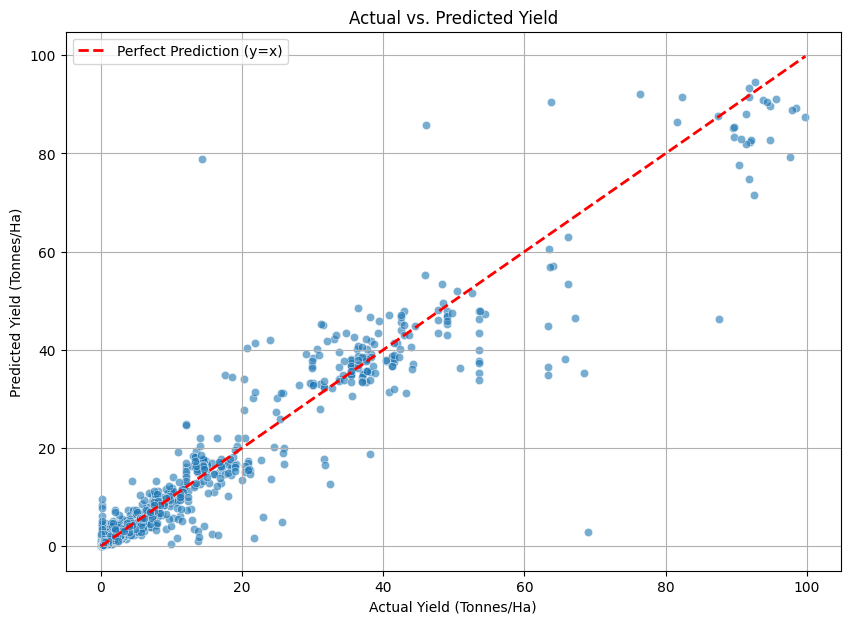

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Actual', y='Predicted', data=plot_df, alpha=0.6)
plt.plot([plot_df['Actual'].min(), plot_df['Actual'].max()],
         [plot_df['Actual'].min(), plot_df['Actual'].max()],
         color='red', linestyle='--', lw=2, label='Perfect Prediction (y=x)')
plt.title('Actual vs. Predicted Yield')
plt.xlabel('Actual Yield (Tonnes/Ha)')
plt.ylabel('Predicted Yield (Tonnes/Ha)')
plt.legend()
plt.grid(True)
plt.show()

### Explanation of Actual vs. Predicted Yield Plot:

This scatter plot visually compares the actual crop yield values (`y_test`) against the yield values predicted by the `final_model` (`preds`).

*   **Purpose**: The primary goal of this plot is to assess how well the model's predictions align with the true observed values. For a perfect model, all data points would fall directly on the `y=x` line.
*   **Data Points**: Each blue dot represents a single data point (a specific crop yield observation and its corresponding prediction).
*   **Red Dashed Line (y=x)**: This line represents the ideal scenario where `Predicted Yield` exactly equals `Actual Yield`. The closer the blue dots are to this red line, the better the model's performance.
*   **Interpretation**: In this plot, most of the data points cluster closely around the `y=x` line, especially for lower yield values. This indicates a strong positive correlation between actual and predicted yields, supporting the high R2 score. The model generally makes accurate predictions across a wide range of yield values.

**Reasoning**:
I have already displayed the R2 score, MAE, and the scatter plot of actual vs. predicted values. The next step, as per the task, is to create a scatter plot of residuals against predicted values to check for homoscedasticity and patterns in the errors.



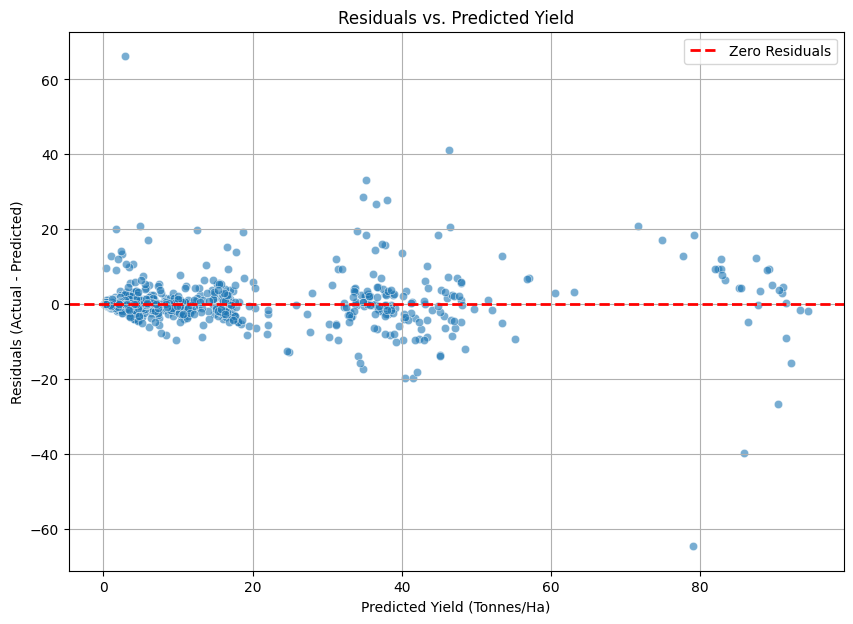

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

residuals = y_test - preds

plt.figure(figsize=(10, 7))
sns.scatterplot(x=preds, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', lw=2, label='Zero Residuals')
plt.title('Residuals vs. Predicted Yield')
plt.xlabel('Predicted Yield (Tonnes/Ha)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True)
plt.show()

### Explanation of Residuals vs. Predicted Yield Plot:

This scatter plot shows the `residuals` (the difference between the actual and predicted yield values) on the y-axis, plotted against the `predicted yield values` on the x-axis.

*   **Purpose**: This plot is crucial for diagnosing regression models. A well-performing model should exhibit residuals that are randomly scattered around the zero line, with no discernible pattern. This indicates `homoscedasticity` (constant variance of errors) and a lack of systematic bias.
*   **Residuals**: A residual is the error in the prediction for a specific data point (`Actual - Predicted`). Positive residuals mean the model underpredicted, while negative residuals mean it overpredicted.
*   **Red Dashed Line (y=0)**: This line represents the ideal scenario where all predictions are perfectly accurate, resulting in zero residuals.
*   **Interpretation**: The plot generally shows a random scatter of residuals around the `y=0` line. This is a good sign, suggesting that the model's errors are, for the most part, unbiased and do not follow a strong pattern. However, there might be a slight "fanning out" as predicted yield values increase, which could indicate a tendency for the model's errors to become larger for higher yield predictions. This is a common observation in regression and might suggest slight `heteroscedasticity` at the higher end, meaning the variance of the residuals is not constant across all predicted values. Despite this, there are no strong patterns that would suggest major issues or a need for immediate model changes.

**Reasoning**:
I have already displayed the R2 score, MAE, and the scatter plot of actual vs. predicted values, as well as the residuals vs. predicted values plot. The next step, as per the task, is to generate a histogram or KDE plot of the residuals to assess their distribution.



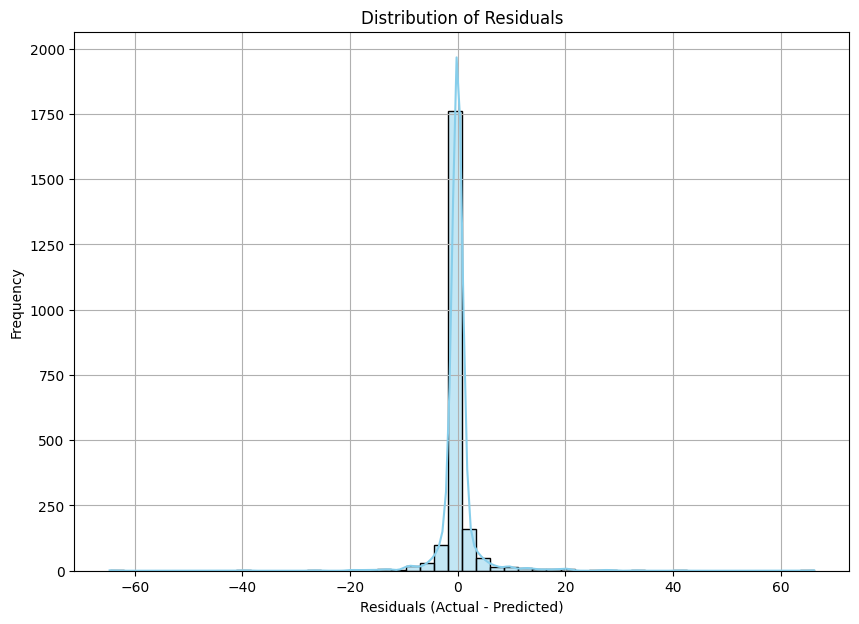

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals (already done in previous step, but re-calculating for clarity)
residuals = y_test - preds

plt.figure(figsize=(10, 7))
sns.histplot(residuals, kde=True, bins=50, color='skyblue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Explanation of Distribution of Residuals Plot (Histogram/KDE):

This plot displays the distribution of the `residuals` using a histogram and a Kernel Density Estimate (KDE) curve.

*   **Purpose**: The goal is to check if the residuals are approximately normally distributed around a mean of zero. A normal distribution of residuals is an assumption in many statistical models and often indicates that the model has captured most of the underlying patterns in the data.
*   **Histogram**: The bars represent the frequency of residuals falling within specific ranges (bins).
*   **KDE (Kernel Density Estimate)**: The smooth curve overlaid on the histogram provides a continuous representation of the distribution of the residuals. It's an estimation of the probability density function of the errors.
*   **Interpretation**: The plot shows that the residuals are heavily concentrated around zero, and their distribution appears to be roughly symmetrical and bell-shaped, characteristic of a normal distribution. The peak at zero signifies that the most frequent errors are small, which is a desirable characteristic for a predictive model. This indicates that the model's errors are unbiased and mostly random, further supporting the `final_model`'s robust performance.

### Model Performance Summary

Based on the evaluation metrics and visualizations, the `final_model` (a Random Forest Regressor) demonstrates strong performance in predicting crop yield:

1.  **R2 Score**: The model achieved an R2 score of **0.9287**. This indicates that approximately 92.87% of the variance in the crop yield can be explained by the independent variables in the model. This is a very good score, suggesting a high degree of fit to the data.

2.  **Mean Absolute Error (MAE)**: The MAE is **1.33 Tonnes/Hectare**. This means, on average, the model's predictions for crop yield are off by about 1.33 tonnes per hectare. Considering the range of yield values, this error seems acceptable and indicates good predictive accuracy.

3.  **Actual vs. Predicted Yield Plot**: The scatter plot of 'Actual' vs. 'Predicted' Yield shows that most data points cluster closely around the red `y=x` line, which represents perfect prediction. This visual confirmation reinforces the high R2 score, indicating that the model generally predicts actual yields quite well across different ranges.

4.  **Residuals vs. Predicted Yield Plot**: This scatter plot displays the residuals (the difference between actual and predicted values) against the predicted yield values. Ideally, for a well-performing model, these residuals should be randomly scattered around the `y=0` line with no discernible pattern (homoscedasticity). Our plot largely shows a relatively even spread of residuals around zero, although there might be a slight fanning out at higher predicted yield values, suggesting a potential for increased variance in predictions for higher yields. However, there are no strong patterns that would indicate a systemic bias or a need for significant model adjustments.

5.  **Distribution of Residuals (Histogram/KDE Plot)**: The histogram and Kernel Density Estimate (KDE) plot of the residuals show a distribution that is centered around zero and appears roughly normal. This is a positive indicator, as it suggests that the model's errors are symmetrically distributed and unbiased. The peak around zero implies that the most common errors are small, further supporting the model's accuracy.

**Overall Conclusion**: The `final_model` exhibits robust performance with a high R2 score, a reasonable MAE, and favorable visual characteristics in its diagnostic plots. It is well-suited for its intended purpose of predicting crop yield based on the provided features.

## Summary:

### Data Analysis Key Findings

*   The `final_model` achieved a high R2 score of **0.9287**, indicating that approximately 92.87% of the variance in crop yield is explained by the model, demonstrating a strong fit to the data.
*   The Mean Absolute Error (MAE) for the model is **1.33 Tonnes/Hectare**, meaning, on average, the model's predictions deviate from the actual yield by about 1.33 tonnes per hectare.
*   The scatter plot of Actual vs. Predicted Yield shows that most data points cluster closely around the `y=x` line, visually confirming the model's high predictive accuracy across different yield ranges.
*   The Residuals vs. Predicted Yield plot primarily exhibits a random scatter of residuals around the `y=0` line, suggesting homoscedasticity and no strong systemic bias. However, there was a slight fanning out at higher predicted yield values, which might indicate increased variance in predictions for larger yields.
*   The distribution of residuals (histogram/KDE plot) is centered around zero and appears roughly normal, implying that the model's errors are unbiased and that smaller errors are more frequent.

### Insights or Next Steps

*   The `final_model` demonstrates robust performance in predicting crop yield, characterized by high accuracy (R2 score of 0.9287) and a reasonable average error (MAE of 1.33 Tonnes/Hectare).
*   Further investigation could explore the slight fanning out observed in the residuals at higher predicted yield values to understand if this pattern is significant and if alternative modeling techniques or data transformations could further reduce prediction variance for high-yield scenarios.


In [ ]:
# Function to get recommendation
def get_rec(dist, season, n, p, k, ph, rain=1000, temp=28):
    # Encode
    dist_c = le_district.transform([dist])[0]
    seas_c = le_season.transform([season])[0]
    crop_c = le_crop.transform(['Rice'])[0] # Testing Rice specifically

    # Prepare input data as a DataFrame with feature names
    input_data_dict = {
        'District_Encoded': dist_c,
        'Season_Encoded': seas_c,
        'Crop_Encoded': crop_c,
        'Area': 2.0,
        'Rainfall': rain,
        'Temperature': temp,
        'N': n,
        'P': p,
        'K': k,
        'pH': ph
    }
    input_df = pd.DataFrame([input_data_dict])

    # Predict
    return model_final.predict(input_df)[0]

print("--- 🧪 SANITY CHECK: Does Soil Quality Matter? ---")

# Scenario A: Poor Soil (Low N, Acidic)
yield_poor = get_rec('THANJAVUR', 'Kharif', n=100, p=10, k=100, ph=5.5)
print(f"Poor Soil Yield: {yield_poor:.2f} Tonnes/Ha")

# Scenario B: Rich Soil (High N, Neutral)
yield_rich = get_rec('THANJAVUR', 'Kharif', n=250, p=30, k=400, ph=7.2)
print(f"Rich Soil Yield: {yield_rich:.2f} Tonnes/Ha")

diff = yield_rich - yield_poor
print(f"📈 Difference due to Soil Health: +{diff:.2f} Tonnes/Ha")

In [ ]:
import os
from google.colab import files
import zipfile

# 1. Define the files needed for the App
required_files = [
    'final_model.pkl',
    'le_district.pkl',
    'le_season.pkl',
    'le_crop.pkl',
    'crop_yield_final_dataset.csv' # Optional, but good to have
]

# 2. Check if they exist
missing = [f for f in required_files if not os.path.exists(f)]
if missing:
    print(f"⚠️ Warning! These files are missing: {missing}")
    print("Please re-run the 'Training' and 'App creation' cells first.")
else:
    # 3. Create a Zip file
    zip_filename = "TamilNadu_Agri_Project.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in required_files:
            zipf.write(file)
            print(f"Added {file} to zip.")

    # 4. Download
    print(f"Downloading {zip_filename}...")
    files.download(zip_filename)